## Homework: Futures Spread Dynamics
### Friday 6th January, 2023

In [1]:
import sys
sys.version

'3.10.8 (main, Nov 24 2022, 08:09:04) [Clang 14.0.6 ]'

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.xkcd()

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm

## Data

Use Quandl to fetch second month quarterly futures prices from the OWF database. 

The first step is to obtain futures prices for each contract from H2021 to Z2022. And then I select the contract with DtT being the smallest available value greater than 30. After all dates from 3 Dec 2020 to 31 Aug 2022 have been filled with price values for futures contracts, the spreads were calculated separately.

In [4]:
myAPIkey = "qUL_zooxYcHueGAiB-D-"

def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key=myAPIkey)
    
    return qdata

def clean_quandl_columns(dataframe):
    
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    
    return renamed_data

In [5]:
year = ["2021","2022"]
quarter = ["H","M","U","Z"]

def fetch_second_month_quarterly(name,trim_start,trim_end):
    
    df = clean_quandl_columns(fetch_quandl(('OWF/'+name+'_1M_IVM',),trim_start=trim_start, trim_end=trim_end))
    df = df[['Future','DtT']]
    
    df.iloc[:] = 0
    
    for y in year:
        for q in quarter:
    
            season = '_'+q+y+'_IVM'
            data = clean_quandl_columns(fetch_quandl(('OWF/'+name+season,),trim_start=trim_start, trim_end=trim_end))
            data = data[['Future','DtT']].rename(columns={"Future": "Future0", "DtT": "DtT0"})

            df = df.join(data)

            df["Future"] = np.where(((df["DtT0"] > 30.0) & (df["DtT"] ==0.0)), df["Future0"],df["Future"])
            df["DtT"] = np.where(((df["DtT0"] > 30.0) & (df["DtT"] ==0.0)), df["DtT0"], df["DtT"])
            
            df = df.drop(columns=['Future0', 'DtT0'])
            
    df = df[df.DtT != 0.0]
    df = df.dropna()
            
    return df

The following function is to check whether my calculated spreads match the examples of data points.

In [6]:
ice_tfm_nym_ng_pairs = {"2021-10-25": -5.751738,
                        "2021-10-28": -2.985990,
                        "2021-11-01": 9.013603}

cbt_fv_cbt_us_pairs = {"2021-11-19": 1.271594,
                       "2021-11-24": -0.658906,
                       "2021-11-26": 1.274656}

def check_data_match(spread,correct_data):
    
    match = True
    
    for k,v in correct_data.items():
        
        date = k
        price = v
        
        if round(spread['Future'][date],6)!=price:
            match = False
            
    if match:
        print("Correct")
    else:
        print("Error in spread calculation")
    

In [7]:
start_date = "2020-12-03"
end_date = "2022-08-31"

**0 ICE TFM TFM versus NYM NG NG × 13.7261**

In [8]:
ice_tfm = fetch_second_month_quarterly('ICE_TFM_TFM',start_date,end_date)
nym_ng = fetch_second_month_quarterly('NYM_NG_NG',start_date,end_date)

ice_tfm_nym_ng = nym_ng['Future']*13.7261 - ice_tfm['Future']
ice_tfm_nym_ng = ice_tfm_nym_ng.to_frame()
ice_tfm_nym_ng = ice_tfm_nym_ng.dropna()
ice_tfm_nym_ng.head()

,Future
Date,
2020-12-03,20.108824
2020-12-04,20.617281
2020-12-07,19.244875
2020-12-08,18.992436
2020-12-09,19.205397


In [9]:
check_data_match(ice_tfm_nym_ng,ice_tfm_nym_ng_pairs)

Correct


**5 CBT FV FV versus CBT US US × 0.7595**

In [10]:
cbt_fv = fetch_second_month_quarterly('CBT_FV_FV',start_date,end_date)
cbt_us = fetch_second_month_quarterly('CBT_US_US',start_date,end_date)

cbt_fv_cbt_us = cbt_us['Future']*0.7595 - cbt_fv['Future']
cbt_fv_cbt_us = cbt_fv_cbt_us.to_frame()
cbt_fv_cbt_us = cbt_fv_cbt_us.dropna()
cbt_fv_cbt_us.head()

,Future
Date,
2020-12-03,5.478250
2020-12-04,4.638547
2020-12-07,5.139047
2020-12-08,5.534719
2020-12-09,5.177516


In [11]:
check_data_match(cbt_fv_cbt_us,cbt_fv_cbt_us_pairs)

Correct


According to the above results, spreads were calculated correctly with the two pairs of futures contracts.

## Analysis

To characterize and analyze the dynamics of each futures spread individually, and then compare the dynamics of the two spreads, I did the following discussion and analysis.

For each futures spread,

* Spread chart
* Spread distribution plots and KDE curve
* Summary statistics of spread
* Calculate differences between spread and N-day rolling average of spread for N = 10, 20, 50, 100
* Dynamics chart and boxplots
* Summary statistics of dynamics

For comparison between the dynamics of the two spreads,

* Correlation between spreads
* Correlation between dynamics

In [12]:
def rolling_average_diff(spread,N):
    
    rolling_average = spread['Future'].rolling(N).mean().to_frame().rename(columns={"Future": "RA"})
    
    diff = spread.join(rolling_average)
    
    diff['Diff'+str(N)] = diff['Future'] - diff['RA']
    diff = diff['Diff'+str(N)].to_frame().dropna()
    # diff = diff['Diff'+str(N)].to_frame()
    
    return diff

In [13]:
def summary(data):
    
    metrics = pd.DataFrame(index = data.columns)
    metrics['Count'] = len(data)
    metrics['Mean'] = round(data.mean(),2)
    metrics['Standard deviation'] = round(data.std(),2)

    metrics['Min'] = round(data.min(),2)
    metrics['Max'] = round(data.max(),2)
    
    metrics['VaR (0.05)'] = round(data.quantile(0.05),2)
    metrics['Quantile 0.25'] = round(data.quantile(0.25),2)
    metrics['Median'] = round(data.median(),2)
    metrics['Quantile 0.75'] = round(data.quantile(0.75),2)
    
    metrics['Skewness'] = round(data.skew(),2)
    metrics['Excess Kurtosis'] = round(data.kurtosis(),2)
    
    return metrics

### ICE_TFM_TFM versus NYM_NG_NG × 13.7261

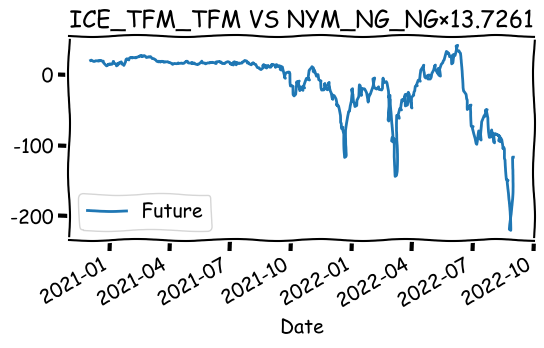

In [14]:
ice_tfm_nym_ng.plot(title="ICE_TFM_TFM VS NYM_NG_NG×13.7261",figsize = (6,3));

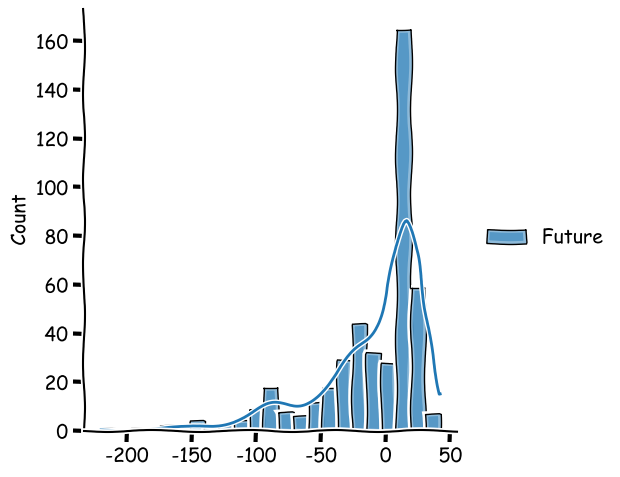

In [15]:
sns.displot(ice_tfm_nym_ng, kde=True);

In [16]:
ice_nym_summary = summary(ice_tfm_nym_ng)
ice_nym_summary

,Count,Mean,Standard deviation,Min,Max,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis
Future,450,-10.9,41.51,-219.84,42.05,-94.73,-27.48,9.61,17.21,-1.73,3.26


The spread ICE_TFM_TFM versus NYM_NG_NG × 13.7261 was stable before 2022, while experienced large fluctuations and sudden drops afterwards. The spread has a highly skewed distribution and heavy tails.

In [17]:
ice_tfm_nym_ng_d10 = rolling_average_diff(ice_tfm_nym_ng,10).rename(columns={"Diff10": "ice_nym_d10"})
ice_tfm_nym_ng_d20 = rolling_average_diff(ice_tfm_nym_ng,20).rename(columns={"Diff20": "ice_nym_d20"})
ice_tfm_nym_ng_d50 = rolling_average_diff(ice_tfm_nym_ng,50).rename(columns={"Diff50": "ice_nym_d50"})
ice_tfm_nym_ng_d100 = rolling_average_diff(ice_tfm_nym_ng,100).rename(columns={"Diff100": "ice_nym_d100"})

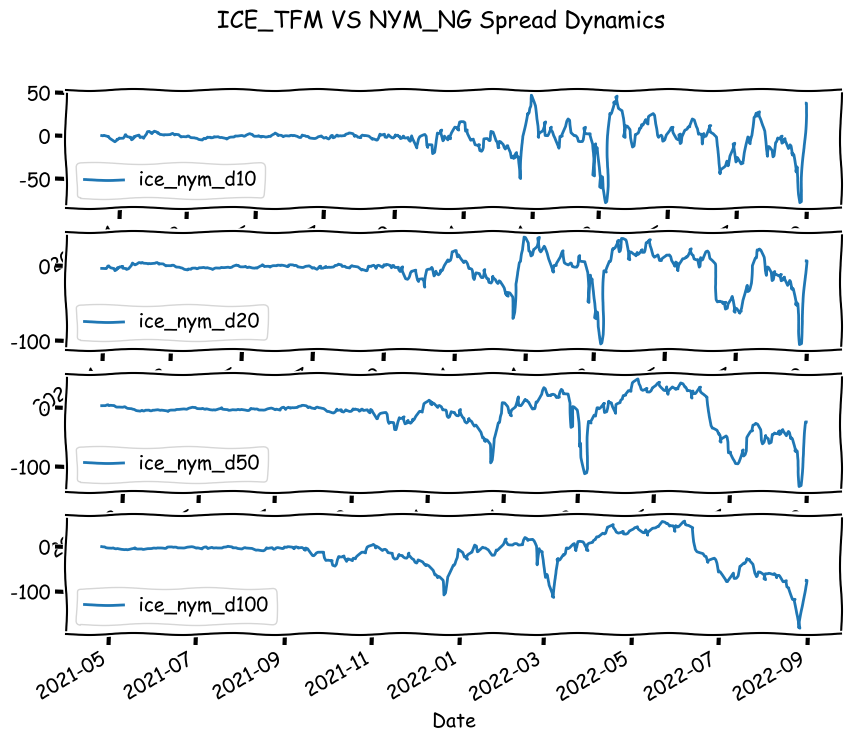

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize = (10,8))

ice_tfm_nym_ng_d10.plot(ax=axes[0])
ice_tfm_nym_ng_d20.plot(ax=axes[1])
ice_tfm_nym_ng_d50.plot(ax=axes[2])
ice_tfm_nym_ng_d100.plot(ax=axes[3])

fig.suptitle("ICE_TFM VS NYM_NG Spread Dynamics");

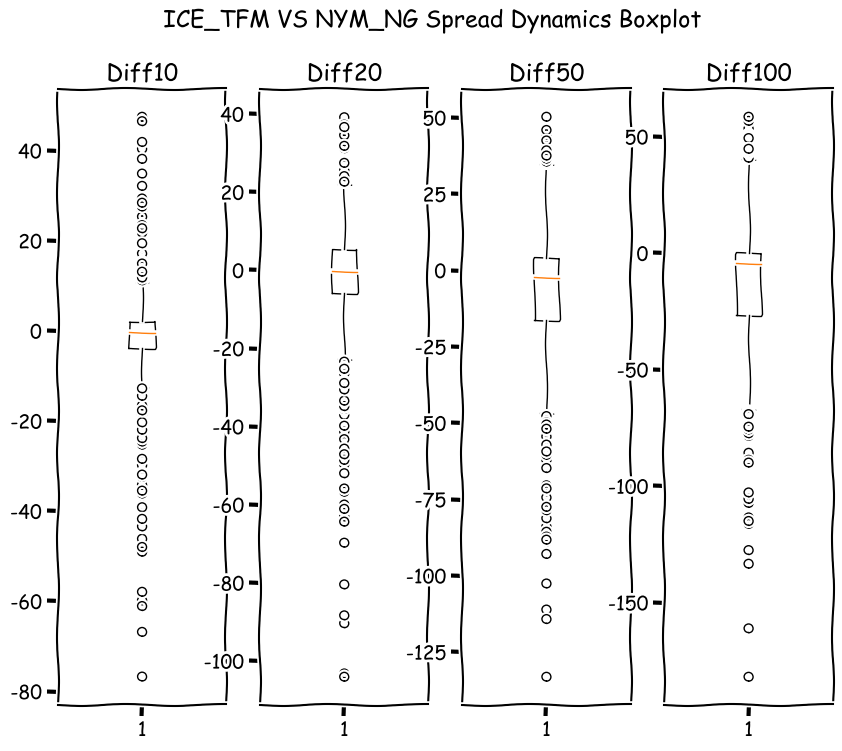

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=4,figsize = (10,8))

axs[0].boxplot(ice_tfm_nym_ng_d10)
axs[0].set_title("Diff10")
axs[1].boxplot(ice_tfm_nym_ng_d20)
axs[1].set_title("Diff20")
axs[2].boxplot(ice_tfm_nym_ng_d50)
axs[2].set_title("Diff50")
axs[3].boxplot(ice_tfm_nym_ng_d100)
axs[3].set_title("Diff100")

fig.suptitle("ICE_TFM VS NYM_NG Spread Dynamics Boxplot");

In [20]:
ice_nym_d10_summary = summary(ice_tfm_nym_ng_d10)
ice_nym_d20_summary = summary(ice_tfm_nym_ng_d20)
ice_nym_d50_summary = summary(ice_tfm_nym_ng_d50)
ice_nym_d100_summary = summary(ice_tfm_nym_ng_d100)

pd.concat([ice_nym_d10_summary, ice_nym_d20_summary, ice_nym_d50_summary, ice_nym_d100_summary], axis=0)

,Count,Mean,Standard deviation,Min,Max,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis
ice_nym_d10,441,-1.83,15.21,-76.79,47.50,-31.24,-3.71,-0.30,2.22,-1.16,5.47
ice_nym_d20,431,-3.54,20.81,-104.07,39.26,-47.61,-5.89,-0.27,5.39,-1.67,4.47
ice_nym_d50,401,-7.90,29.56,-133.14,50.27,-71.44,-16.33,-1.96,4.22,-1.14,1.86
ice_nym_d100,351,-12.87,36.28,-181.89,58.50,-75.66,-26.60,-4.13,0.29,-1.03,2.35


According to the above results of differences between spread and N-day rolling average of spread for N = 10, 20, 50 and 100, we can see that as N gets larger, the mean gets smaller, and the standard deviation gets larger, which indicates the difference is getting more and more spread out as N increases. Boxplots also show the same results.

### CBT_FV_FV versus CBT_US_US × 0.7595

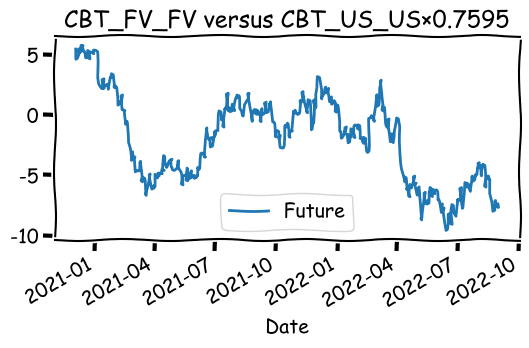

In [21]:
cbt_fv_cbt_us.plot(title="CBT_FV_FV versus CBT_US_US×0.7595",figsize = (6,3));

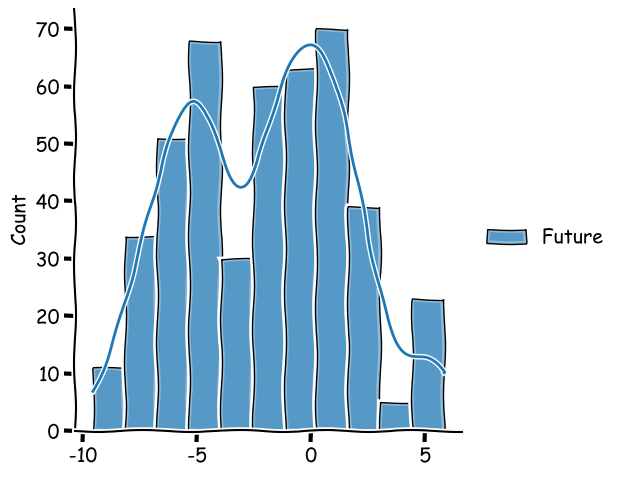

In [22]:
sns.displot(cbt_fv_cbt_us,kde=True);

In [23]:
cbt_cbt_summary = summary(cbt_fv_cbt_us)
cbt_cbt_summary

,Count,Mean,Standard deviation,Min,Max,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis
Future,454,-2.05,3.54,-9.56,5.82,-7.54,-5.06,-1.69,0.58,0.06,-0.8


The spread CBT_FV_FV versus CBT_US_US × 0.7595 fluctuates slightly and declines in during this period. The standard deviation and the skewness are small. The kurtosis value is negative, which indicates that the distribution has lighter tails than the normal distribution.

In [24]:
cbt_fv_cbt_us_d10 = rolling_average_diff(cbt_fv_cbt_us,10).rename(columns={"Diff10": "cbt_cbt_d10"})
cbt_fv_cbt_us_d20 = rolling_average_diff(cbt_fv_cbt_us,20).rename(columns={"Diff20": "cbt_cbt_d20"})
cbt_fv_cbt_us_d50 = rolling_average_diff(cbt_fv_cbt_us,50).rename(columns={"Diff50": "cbt_cbt_d50"})
cbt_fv_cbt_us_d100 = rolling_average_diff(cbt_fv_cbt_us,100).rename(columns={"Diff100": "cbt_cbt_d100"})

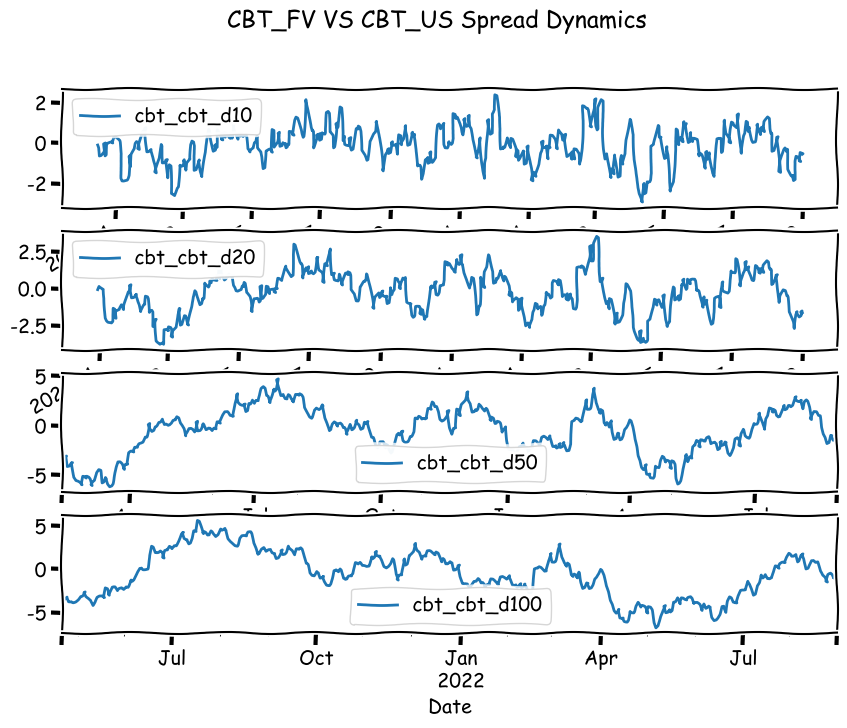

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize = (10,8))

cbt_fv_cbt_us_d10.plot(ax=axes[0])
cbt_fv_cbt_us_d20.plot(ax=axes[1])
cbt_fv_cbt_us_d50.plot(ax=axes[2])
cbt_fv_cbt_us_d100.plot(ax=axes[3])

fig.suptitle("CBT_FV VS CBT_US Spread Dynamics");

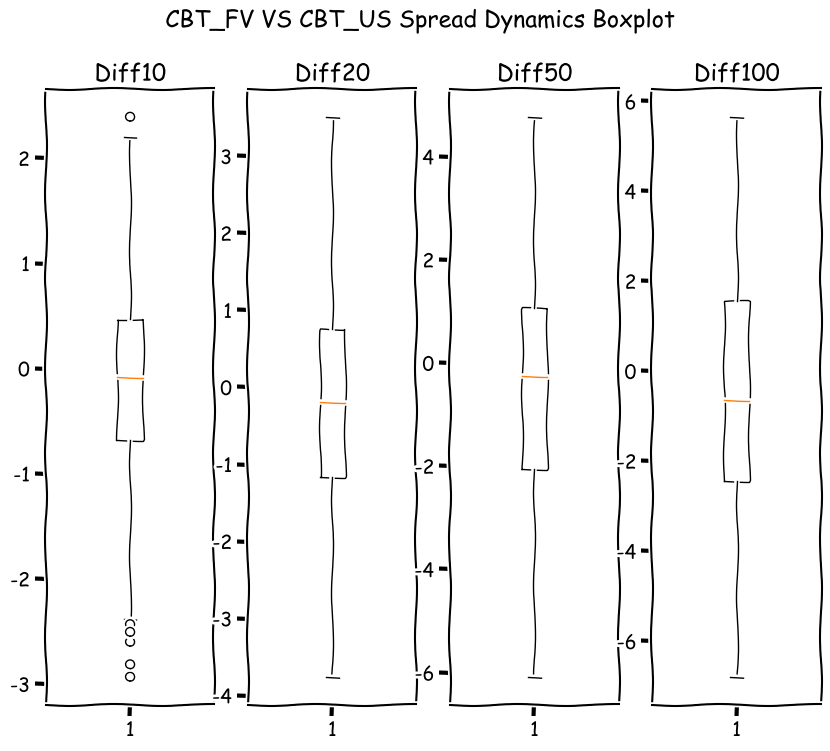

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=4,figsize = (10,8))

axs[0].boxplot(cbt_fv_cbt_us_d10)
axs[0].set_title("Diff10")
axs[1].boxplot(cbt_fv_cbt_us_d20)
axs[1].set_title("Diff20")
axs[2].boxplot(cbt_fv_cbt_us_d50)
axs[2].set_title("Diff50")
axs[3].boxplot(cbt_fv_cbt_us_d100)
axs[3].set_title("Diff100")

fig.suptitle("CBT_FV VS CBT_US Spread Dynamics Boxplot");

In [27]:
cbt_cbt_d10_summary = summary(cbt_fv_cbt_us_d10)
cbt_cbt_d20_summary = summary(cbt_fv_cbt_us_d20)
cbt_cbt_d50_summary = summary(cbt_fv_cbt_us_d50)
cbt_cbt_d100_summary = summary(cbt_fv_cbt_us_d100)

pd.concat([cbt_cbt_d10_summary, cbt_cbt_d20_summary, cbt_cbt_d50_summary, cbt_cbt_d100_summary], axis=0)

,Count,Mean,Standard deviation,Min,Max,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis
cbt_cbt_d10,445,-0.13,0.92,-2.93,2.39,-1.76,-0.68,-0.08,0.48,-0.29,0.17
cbt_cbt_d20,435,-0.26,1.37,-3.76,3.51,-2.60,-1.16,-0.19,0.76,-0.24,-0.29
cbt_cbt_d50,405,-0.53,2.33,-6.08,4.77,-5.17,-2.05,-0.26,1.07,-0.39,-0.42
cbt_cbt_d100,355,-0.55,2.67,-6.80,5.65,-4.89,-2.43,-0.64,1.56,-0.05,-0.72


For differences calculated with spread of CBT_FV_FV versus CBT_US_US × 0.7595, as N gets larger, the mean value gets smaller, and the standard deviation gets larger, which is the same finding as ICE_TFM_TFM versus NYM_NG_NG × 13.7261. Besides, the kurtosis value gets larger, the skewness value remains small. Though the differences data are getting more spread out, there are no outliers in the boxplots.

### Compare

In [28]:
def correlation(data,name):
    
    columns = data.columns
    c1 = columns[0]
    c2 = columns[1]

    corr = pd.DataFrame(index = ['Correlation'])
    corr[name] = round(data[c1].corr(data[c2]),4)
    
    return corr

In [29]:
ice_tfm_nym_ng_ = ice_tfm_nym_ng.rename(columns={"Future": "ice_nym"})
cbt_fv_cbt_us_ = cbt_fv_cbt_us.rename(columns={"Future": "cbt_cbt"})

df_spread = ice_tfm_nym_ng_.join(cbt_fv_cbt_us_)
correlation(df_spread,"spread")

,spread
Correlation,0.1735


In [30]:
df_d10 = ice_tfm_nym_ng_d10.join(cbt_fv_cbt_us_d10)
corr_d10 = correlation(df_d10,"diff10")

df_d20 = ice_tfm_nym_ng_d20.join(cbt_fv_cbt_us_d20)
corr_d20 = correlation(df_d20,"diff20")

df_d50 = ice_tfm_nym_ng_d50.join(cbt_fv_cbt_us_d50)
corr_d50 = correlation(df_d50,"diff50")

df_d100 = ice_tfm_nym_ng_d100.join(cbt_fv_cbt_us_d100)
corr_d100 = correlation(df_d100,"diff100")

pd.concat([corr_d10, corr_d20, corr_d50, corr_d100], axis=1)

,diff10,diff20,diff50,diff100
Correlation,-0.2032,-0.2397,-0.3917,-0.3497


According to the above results, neither the two spreads nor their dynamics have high correlation with each other.